+ 数据并行 vs 模型并行
  + 数据并行：模型拷贝、数据在batch上进行split/chunk，即每个设备上都有一份模型的拷贝，每个设备处理一部分输入(batch_size / device_num)
  + 模型并行：数据拷贝、模型split/chunk(单卡放不下模型的情况)
+ DP架构的本质是ps-worker架构：

  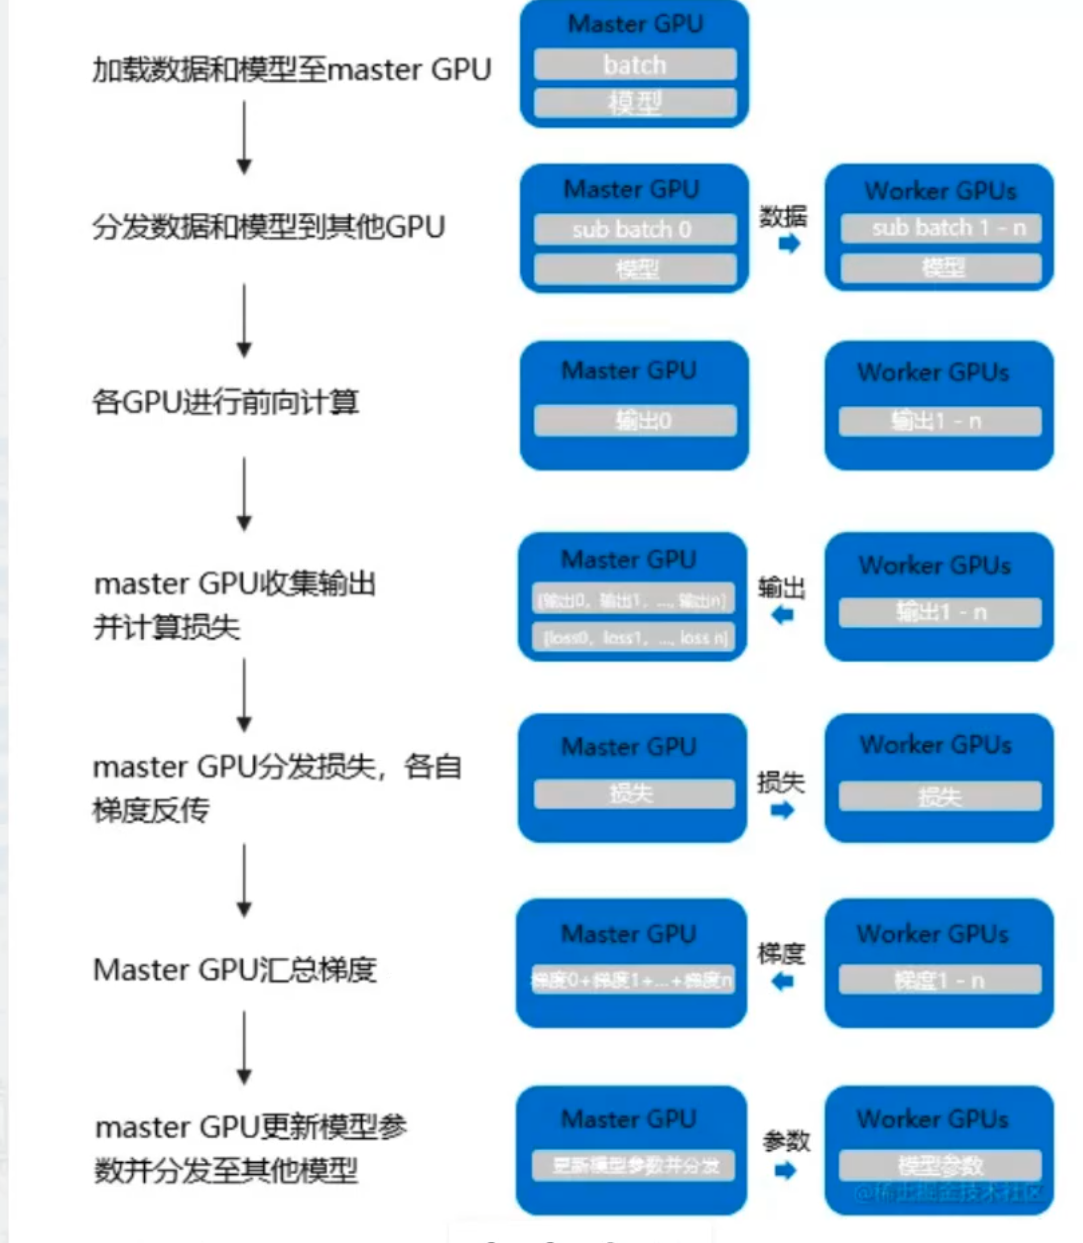

+ DP的主要缺点在于：
  + 单进程多线程：受限于python的GIL，会带来性能开销，速度很慢
  + 主卡性能和通信开销容易成为瓶颈，GPU利用率通常很低
  + 不支持模型并行

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

input_size = 10
hidden_size = 20
output_size = 5
num_layers = 2
batch_size = 32
data_size = 1000

In [11]:
class SimpleDataset(Dataset):
    def __init__(self, size):
        self.data = torch.randn(size, input_size)
        self.labels = torch.randint(0, 1, (size, output_size))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

random_loader = DataLoader(SimpleDataset(data_size), batch_size=batch_size, shuffle=True)

In [12]:
for batch in random_loader:
    data, labels = batch
    print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")
    break

Data shape: torch.Size([32, 10]), Labels shape: torch.Size([32, 5])


In [13]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [14]:
model = Model(input_size, hidden_size, output_size, num_layers)

# device_ids = None 决定参与训练的GPU有哪些
# output_device = None 决定汇总结果的GPU是哪个
model = nn.DataParallel(model)

In [17]:
for data in random_loader:
    inputs, labels = data
    input = inputs.to('cuda:0')
    output = model(input)
    print("Outside: input size", input.size(),
          "output_size", output.size())
    break

Outside: input size torch.Size([32, 10]) output_size torch.Size([32, 5])
